In [120]:
from Source.load_data import *
from Hyperparameters.params_TNG_CV import *
from Source.constants import *
use_model, learning_rate, weight_decay, n_layers, k_nn, n_epochs, training, simsuite, simset, n_sims = params
simpath = simpathroot + simsuite + "/"+simset+"_"
path = simpath + str(2)+"/fof_subhalo_tab_033.hdf5"
tab, HaloMass, HaloPos, HaloVel, halolist = general_tab(path)

In [121]:
ind = 1

tab_halo = tab[tab[:,0]==ind][:,1:] #1upwards because we don't need the hosthalo id from original tab
tab_halo.shape

(26, 8)

In [122]:
# Consider only halos with at least one satellite galaxy (besides the central)
if tab_halo.shape[0]>1:

    # Otherwise, write the positions and velocities as the relative position and velocity to the host halo
    tab_halo[:,0:3] -= HaloPos[ind]
    tab_halo[:,-3:] -= HaloVel[ind]

    # Correct periodic boundary effects
    tab_halo[:,:3] = correct_boundary(tab_halo[:,:3])

    # If use velocity, compute the betrag of the velocities vector and create a new table with these values
    subhalovel = np.log10(np.sqrt(np.sum(tab_halo[:,-3:]**2., 1)))  # use this way in case you normalize velocities
    newtab = np.column_stack((tab_halo[:,:-3], subhalovel))

In [123]:
# Take as global quantities of the halo the number of subhalos and the total stellar mass
u = np.zeros((1,2), dtype=np.float32)
u[0,0] = tab_halo.shape[0]  # number of subhalos
u[0,1] = np.log10(np.sum(10.**tab_halo[:,3]))

# Create the graph of the halo
# x: features (includes positions), pos: positions, u: global quantity
graph = Data(x=torch.tensor(newtab, dtype=torch.float32), pos=torch.tensor(tab_halo[:,:3], dtype=torch.float32), y=torch.tensor(np.log10(HaloMass[ind]), dtype=torch.float32), u=torch.tensor(u, dtype=torch.float))

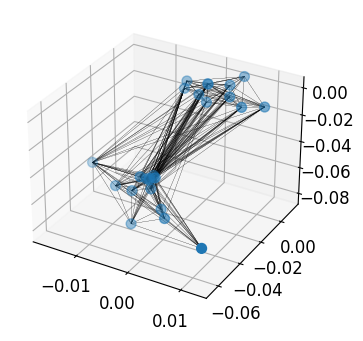

In [124]:
from torch_cluster import radius_graph
import matplotlib.pyplot as plt

k_nn = 0.07
edge_index = radius_graph(graph.pos, r=k_nn)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection ="3d")
pos = graph.x[:,:3]

# Draw lines for each edge
if edge_index is not None:
    for (src, dst) in edge_index.t().tolist():

        src = pos[src].tolist()
        dst = pos[dst].tolist()

        ax.plot([src[0], dst[0]], [src[1], dst[1]], zs=[src[2], dst[2]], linewidth=0.1, color='black')

# Plot nodes
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=50, zorder=1000)

#plt.axis('off')
fig.savefig("Plots/visualize_graph_"+str(ind), bbox_inches='tight', dpi=300)



In [139]:
from Source.network import *
 
in_channels = graph.x.shape[1]
use_model = params[0]
node_features = 6
model = ModelGNN(use_model, n_layers, k_nn , node_features)

In [145]:
x_i = graph.x[1]
x_j = graph.x[2]

input = torch.cat([x_i,x_i-x_j], dim=-1)

In [146]:
input.shape

torch.Size([12])

In [147]:
input

tensor([-0.0046, -0.0312, -0.0549,  0.6969,  0.8679,  0.1449, -0.0172,  0.0338,
         0.0040,  0.3246,  0.3953, -0.2992])

In [148]:
x_i

tensor([-0.0046, -0.0312, -0.0549,  0.6969,  0.8679,  0.1449])